# TempEst-NEWT Case Studies

This Notebook covers preliminary data exploration through case studies to inform development of the watershed-scale component of the TempEst-NEXT model.

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
from NEWT import Watershed as WS
pd.options.mode.chained_assignment = None

In [2]:
base_path = r"X:\Rio.Data\StreamTemperature\NEXT\ReadyData\daymet_aoi"
gsamp = pd.read_csv(r"C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\DataRetrieval\GageSample.csv",
                   dtype={"id": "str"})

In [3]:
def mergeit(out="AllData.csv", resume=-1):
    dat = pd.read_csv(r"C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\DataRetrieval\AllGageData.csv",
                      dtype={"id": "str"})
    ids = dat["id"].unique()
    dat["date"] = pd.to_datetime(dat["date"])
    bad_count = 0
    for (index, cid) in enumerate(gsamp["id"]):
        # Fix leading zeroes.
        data = dat[dat["id"] == cid] if cid in ids else dat[dat["id"] == "0" + cid]
        if index > resume:
            try:
                weather_path = base_path + "\\USGS-" + cid + ".csv"
                weather = pd.read_csv(weather_path)
                weather["date"] = pd.to_datetime(weather["datetime"]).dt.normalize()
                wmean = weather.pivot(index="date", columns="variable", values="mean")
                result = data[["id", "date", "temperature.mean"]].merge(wmean, on="date")
                result.to_csv(out,
                                mode="w" if index == 0 else "a",
                                header=(index == 0),
                                index=False)
            except FileNotFoundError:
                bad_count = bad_count + 1
            except Exception as e:
                print(e)
    print(bad_count)

In [4]:
# mergeit()

In [5]:
data = pd.read_csv("AllData.csv", dtype={"id": "str"})
data["date"] = pd.to_datetime(data["date"])
print(len(data["id"].unique()))
data

954


,id,date,temperature.mean,prcp,srad,swe,tmax,tmin,vp
0,13011820,2020-03-31,0.100000,17.110126,248.76216,NaN,1.795443,NaN,444.26370
1,13011820,2020-04-01,0.100000,7.202532,403.38873,NaN,0.030759,NaN,270.94354
2,13011820,2020-04-02,0.100000,2.167848,600.86993,NaN,-3.442405,NaN,132.77936
3,13011820,2020-04-03,0.100000,2.987468,509.44165,NaN,-2.238481,NaN,138.35303
4,13011820,2020-04-04,0.100000,6.021518,465.97583,NaN,3.509114,NaN,284.43704
...,...,...,...,...,...,...,...,...,...
3060720,03047000,2022-12-27,0.540625,0.000000,268.23563,NaN,-2.151775,NaN,207.79785
3060721,03047000,2022-12-28,0.407292,0.000000,279.93356,NaN,5.509683,NaN,310.02664
3060722,03047000,2022-12-29,0.428125,0.000000,290.53482,NaN,13.100331,NaN,354.31638
3060723,03047000,2022-12-30,0.661458,0.000000,285.53320,NaN,17.568270,NaN,512.88240


In [6]:
def get_candidate(cid):
    return data[data["id"] == cid]
    # data = pd.read_csv(r"C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\DataRetrieval\AllGageData.csv",
    #                   dtype={"id": "str"})
    # data["date"] = pd.to_datetime(data["date"])
    # weather_path = base_path + "\\USGS-" + cid + ".csv"
    # weather = pd.read_csv(weather_path)
    # stdat = data[data["id"] == cid]
    # weather["date"] = pd.to_datetime(weather["datetime"]).dt.normalize()
    # wmean = weather.pivot(index="date", columns="variable", values="mean")
    # return stdat[["date", "temperature.mean"]].merge(wmean, on="date")

In [7]:
# This is Eagle River Below Milk Creek Near Wolcott, CO
# Appears to be unregulated, freezes in winter, max temperature ~20 C, discharge ~50-2000 cfs,
# elevation ~2100 m
candidate_eagle = "394220106431500"

cid = candidate_eagle
csd = get_candidate(cid)

# Modeled Anomaly

Using a modified (dynamic) SCHEMA, the first step is to design the modeled daily anomaly approach.  This presumably won't directly copy from an LST-based approach, and hopefully we can achieve better accuracy than an NSE of ~0.45.

A few thoughts at the single-watershed (calibrated) scale:

- Can we decompose anomaly response into unit thermohydrographs?  There are probably established approaches to functional decomposition of this form.  Wavelets?
- Does sensitivity vary dynamically with season?
- Some ideas for dynamic sensitivity drivers:
  - Snowpack
  - Sustained subzero air temperature (frozen river won't randomly thaw)
  - Precipitation has little overall effect, but it may increase the response sensitivity to an anomaly
- If we end up sticking with a rolling mean, the model code should just keep a list of relevant observations and drop the old ones instead of reprocessing the whole dataset every day.

## Prepare Anomaly Data

In [327]:
def anomilize(data):
    data["day"] = data["date"].dt.day_of_year
    try:
        data = data.merge(rts.ThreeSine.from_data(data.rename(columns={"temperature.mean": "temperature"})).generate_ts(), on="day")  # adds `actemp`
        data["st_anom"] = data["temperature.mean"] - data["actemp"]
        # data["stm_anom"] = data["temperature.max"] - data["actemp"]
        data = data.merge(data.groupby("day")["tmax"].mean().rename("tmax_day"), on="day")
        data["at_anom"] = data["tmax"] - data["tmax_day"]
        data = data.merge(data.groupby("day")["vp"].mean().rename("vp_day"), on="day")
        data["vp_anom"] = data["vp"] - data["vp_day"]
        return data
    except ValueError:
        return data.assign(at_anom=np.NaN, st_anom=np.NaN, actemp=np.NaN)

In [52]:
ac = anomilize(csd)
ac

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_21832\215106962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day"] = data["date"].dt.day_of_year


,id,date,temperature.mean,prcp,srad,swe,tmax,tmin,vp,day,actemp,st_anom,tmax_day,at_anom
0,394220106431500,2007-10-01,9.000000,5.684494,315.89957,NaN,14.848049,-0.734184,579.70483,274,9.243199,-0.243199,13.567267,1.280782
1,394220106431500,2007-10-02,10.131250,1.734530,275.11975,NaN,9.678488,-0.441640,593.09650,275,8.977150,1.154100,12.926053,-3.247565
2,394220106431500,2007-10-03,9.704167,0.000000,406.70746,NaN,14.444156,-0.781746,576.83930,276,8.710292,0.993875,14.263163,0.180993
3,394220106431500,2007-10-04,9.695833,0.405152,387.00244,NaN,16.709568,1.858799,699.66880,277,8.442873,1.252960,13.341467,3.368101
4,394220106431500,2007-10-05,10.901042,0.000000,334.83810,NaN,15.645824,3.965081,813.42255,278,8.175141,2.725900,11.766584,3.879240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,394220106431500,2022-12-27,0.000000,10.553032,191.49033,NaN,4.154530,NaN,424.24790,361,-0.020726,0.020726,-2.526517,6.681047
5535,394220106431500,2022-12-28,0.000000,8.184340,210.25845,NaN,0.119703,NaN,298.54263,362,-0.032142,0.032142,-4.035087,4.154790
5536,394220106431500,2022-12-29,0.000000,1.973018,218.12827,NaN,-7.772742,NaN,180.07483,363,-0.041320,0.041320,-4.550913,-3.221829
5537,394220106431500,2022-12-30,0.000000,7.100912,229.40940,NaN,-4.506784,NaN,182.08226,364,-0.048276,0.048276,-2.946670,-1.560114


<Axes: xlabel='date'>

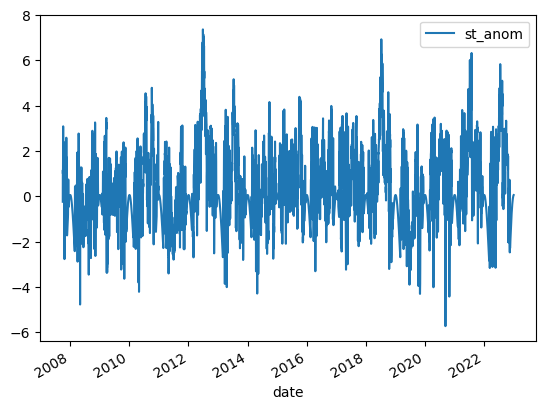

In [53]:
ac.plot(x="date", y="st_anom")  # definite autocorrelations.

<Axes: xlabel='date'>

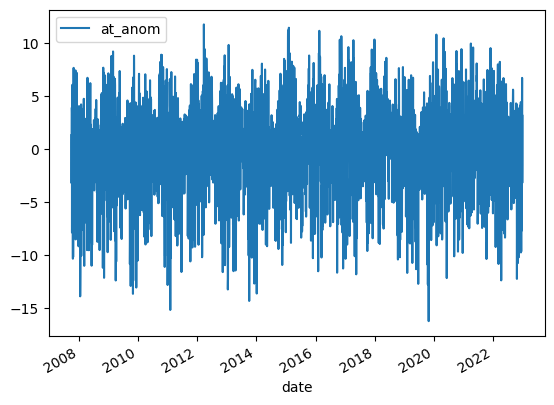

In [54]:
ac.plot(x="date", y="at_anom")

There is an anomaly autocorrelation, which begins quite high (~0.9).  There appear to be two ranges of decay: it drops to ~0.1 by day 40 in an exponentialish fashion, then remains nearly constant until day 100 before dropping to 0 by day 120.

(0.0, 120.0)

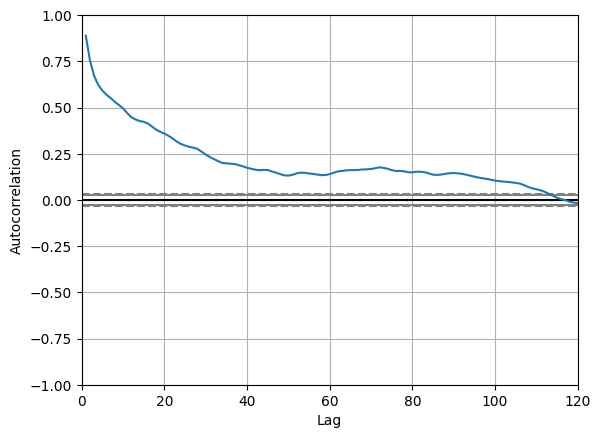

In [42]:
pdp.autocorrelation_plot(ac["st_anom"])
plt.xlim(0, 120)

## Deconvolution to Unit Thermohydrographs

Can it be done and does it make sense?

This is a sort of deconvolution problem.  For ST $s$ and AT $a$, where the daily coefficient of the unit thermohydrograph $K$ is $k_x=K(x)$:

$$
    s(t) = \sum_{i=0}^{t} a_{i}\cdot k_{t-i}
$$

I.e.,

$$
    s(t) = A\cdot (k_t, k_{t-1}, ..., k_0) = A\cdot (0..0, K)
$$

Where the coefficient array $K$ is concatenated with a series of zeroes for padding.

So for a matrix of zero-padded $K$ rows, $\mathbb{K}$, we have $S = \mathbb{K}A$.

This is easy to solve for $A$, but this time we want an optimal, approximate solution for $\mathbb{K}$, knowing $S$ and $A$.

It appears that unit hydrograph decomposition is an active research problem.  Fenton (2024) summarizes prior work at: https://www.sciencedirect.com/science/article/pii/S0022169424004293

In lieu of that, let's just solve a linear relationship between $s$ and a lagged subset of $a$.

Doesn't work that well for Eagle River, where the correlation of that fit is poor (R2~0.25).

0   -0.702850
1   -0.614695
2   -0.761736
3   -1.537886
4   -1.277129
5   -0.208265
6   -0.697764
7   -1.860349
8   -1.338035
9   -0.277074
dtype: float64


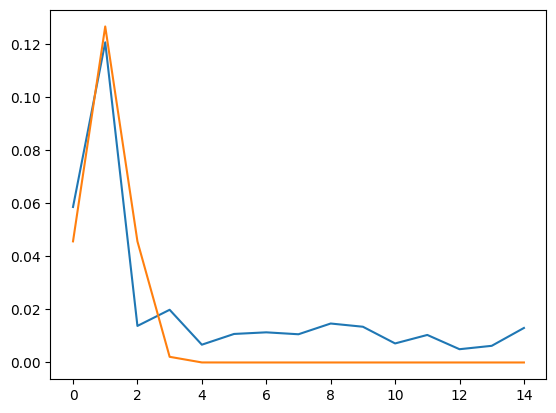

In [218]:
N = 14
y = np.array([ac["st_anom"]]).transpose()[N:,]
x0 = ac["at_anom"]
xs = np.array([x0] + [x0.shift(n) for n in range(1,N+1)]).transpose()[N:,]
sol = np.linalg.lstsq(xs, y, rcond=None)[0]
# print(np.sqrt(soln[1] / len(x0)))
prd = pd.Series((xs @ sol)[:,0])
ax = pd.Series(sol[:,0]).plot()
# pd.Series(scipy.stats.lognorm.pdf(np.arange(0, N+1), 10)*24+0.1).plot(ax=ax)
# conv = scipy.stats.poisson.pmf(np.arange(0, N+1), 1)/3
conv = scipy.stats.norm.pdf(np.arange(0, N+1), 1, 0.7) / 4.5
# conv = np.concatenate(([0.06], np.exp(-np.arange(1, N+1)) * 0.35))
pd.Series(conv).plot(ax=ax)
print(prd[:10])

5525
5525


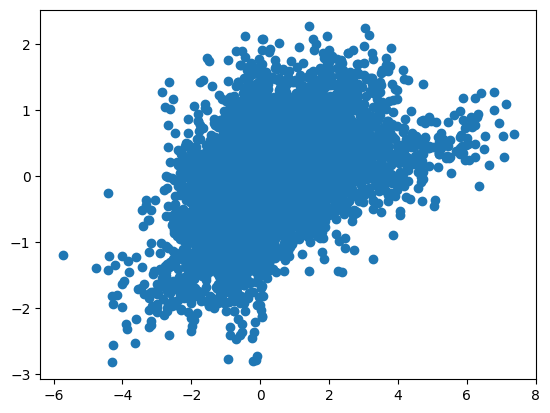

In [289]:
# conv = np.concatenate(([0.9], np.exp(-np.arange(1, 15)/2.1) * 1.5 + 0.15))
# Faster than a regular convolution
# TODO: I think it's backwards
yp = scipy.signal.fftconvolve(x0, conv, mode="same")[7:-7]
print(len(y))
print(len(yp))
plt.scatter(y, yp)

## Large-Set Comparison

Eagle River does not work that well because there's simply a low correlation between AT and ST anomaly (probably necessary to account for snowpack/precip).  What do distributions look like across sites?

In [340]:
def to_coefs(ac, N=14):
    y = np.array([ac["st_anom"]]).transpose()[N:,]
    x0 = ac["at_anom"]
    hu0 = ac["vp_anom"]
    xs = np.array([x0] + [x0.shift(n) for n in range(1,N+1)] + [hu0] + [hu0.shift(n) for n in range(1,N+1)]).transpose()[N:,]
    try:
        sol = np.linalg.lstsq(xs, y, rcond=None)[0]
        return pd.DataFrame({"I": np.arange(0, N+1), "kt": sol[:(N+1),0], "kv": sol[(N+1):,0]})
    except:
        return pd.DataFrame({"I": np.arange(0, N+1), "kt": np.NaN, "kv": np.NaN})

In [330]:
anomed = data.groupby("id").apply(anomilize, include_groups=False)

In [341]:
coefs = anomed.groupby("id").apply(to_coefs).dropna()

Surprisingly, it seems to be quite consistent that the response is dominated by lag-1 air temperature, and the form does look rather log-normal.  The medians are fit quite well by a log-normal distribution with a standard deviation of 1, divided by 2.5.

Humidity response seems to be dominated by day 0 and 1, but is quite variable.

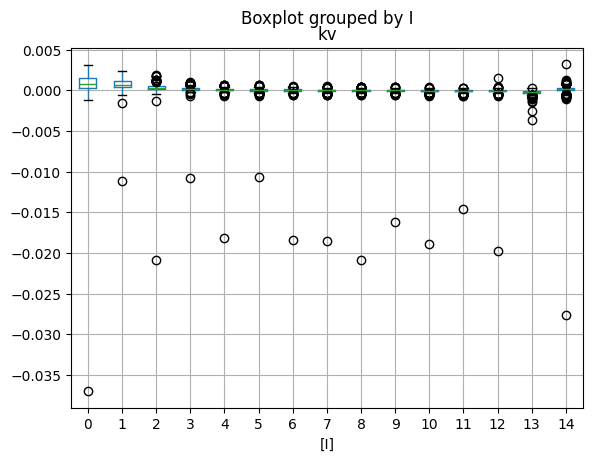

In [349]:
ax = coefs[["I", "kv"]].boxplot(by="I")
# prco = pd.Series(scipy.stats.norm.pdf(np.arange(-1, 15), 1, 0.7) / 3)
prco = pd.Series(scipy.stats.lognorm.pdf(np.arange(0, 15), 1)/2.5, index=range(1,16))
# prco.plot(ax=ax)

In [374]:
def convolver(data):
    # Assume data is anom'ed and grouped.  Relationship zeroes-out at day 7, so ignore after that.
    conv = scipy.stats.lognorm.pdf(np.arange(0, 7), 1)
    # inward = len(conv) // 2
    data["anom_atmod"] = scipy.signal.fftconvolve(data["at_anom"], conv, mode="full")[:-(len(conv) - 1)]
    data["anom_hummod"] = scipy.signal.fftconvolve(data["vp_anom"], [1,1], mode="full")[:-1]
    try:
        sol = np.linalg.lstsq(np.array(data[["anom_atmod", "anom_hummod"]]), data["st_anom"].to_numpy().transpose(), rcond=None)[0]
        data["anom_mod"] = data["anom_atmod"] * sol[0] + data["anom_hummod"] * sol[1]
        data["at_coef"] = sol[0]
        data["vp_coef"] = sol[1]
        return data
    except:
        pass

In [375]:
mod = anomed.groupby("id").apply(convolver, include_groups=False)

This actually works reasonably well, almost as well as the TE2 model - and that, just with AT (no vapor pressure)!  So, that's probably about as good as it will get.  With vapor pressure, R2 is up to about 0.41.  Median mean bias is -0.38 C and median MAE is 1.3 C.  Median NSE is 0.33, mean slightly lower - presumably low NSE is due to the bias.  Where'd the bias come from and why do the vast majority of sites have a bias?

In [376]:
mod.groupby("id").apply(lambda x: x["st_anom"].corr(x["anom_mod"])**2).describe()

count    581.000000
mean       0.407624
std        0.217341
min        0.001699
25%        0.243965
50%        0.413688
75%        0.598519
max        0.805084
dtype: float64

In [377]:
mod.groupby("id").apply(lambda x: np.mean(x["anom_mod"] - x["st_anom"])).dropna().describe()

count    581.000000
mean      -0.378141
std        1.186149
min       -2.051897
25%       -0.784561
50%       -0.499984
75%       -0.086056
max       25.147277
dtype: float64

In [378]:
mod.groupby("id").apply(lambda x: 1 - np.mean((x["anom_mod"] - x["st_anom"])**2) / np.std(x["st_anom"])**2).dropna().describe()

count    581.000000
mean       0.305517
std        0.236744
min       -0.594666
25%        0.147831
50%        0.329300
75%        0.496279
max        0.727127
dtype: float64

<Axes: >

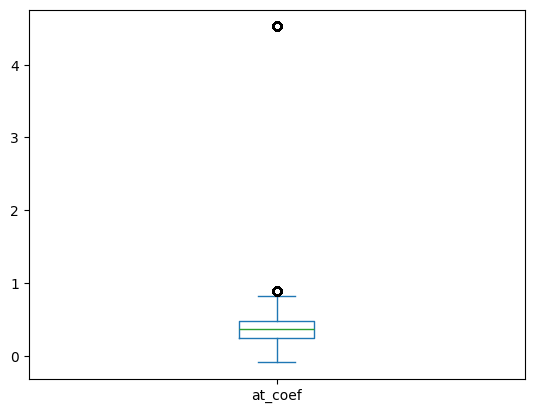

In [380]:
mod["at_coef"].plot.box()

<Axes: >

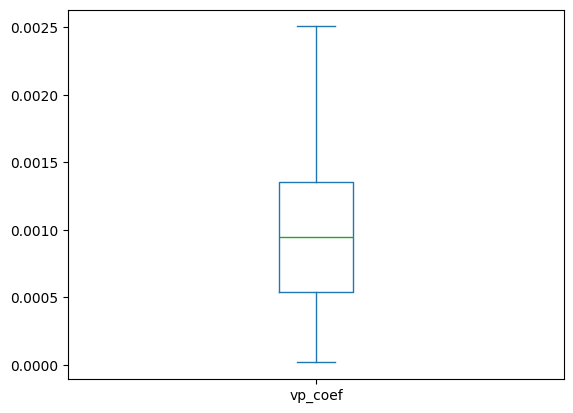

In [383]:
mod[mod["vp_coef"] > 0]["vp_coef"].plot.box()

## Dynamic Sensitivity

At sites, does the *daily* coefficient correlate with SWE or precipitation?  Ignore humidity, its impact is low.

There is no identifiable correlation.  SWE might be more relevant for assessing three-sine timing.

Time to build a model class!

In [400]:
def daily_coef(data):
    # Assume data is anom'ed and grouped.  Relationship zeroes-out at day 7, so ignore after that.
    conv = scipy.stats.lognorm.pdf(np.arange(0, 7), 1)
    # inward = len(conv) // 2
    data["anom_atmod"] = scipy.signal.fftconvolve(data["at_anom"], conv, mode="full")[:-(len(conv) - 1)]
    data["anom_hummod"] = scipy.signal.fftconvolve(data["vp_anom"], [1,1], mode="full")[:-1]
    nzr = data[abs(data["anom_atmod"]) > 0.1]
    nzr["at_coef"] = nzr["st_anom"] / nzr["anom_atmod"]
    return nzr

def get_cor(data):
    return pd.DataFrame({
        "SWE": [data["at_coef"].corr(data["swe"])],
        "p": data["at_coef"].corr(data["prcp"])
    })

In [396]:
coefs = anomed.groupby("id").apply(daily_coef)

In [401]:
coef_cor = coefs.groupby("id").apply(get_cor)

C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [403]:
coef_cor.describe()

,SWE,p
count,548.000000,581.000000
mean,-0.009530,0.008485
std,0.042831,0.021890
min,-0.131907,-0.072992
25%,-0.036665,-0.005464
50%,-0.008080,0.008940
75%,0.015613,0.021701
max,0.166994,0.089249


In [404]:
(coef_cor**2).describe()

,SWE,p
count,5.480000e+02,5.810000e+02
mean,1.921959e-03,5.503335e-04
std,3.076771e-03,9.059363e-04
min,2.393890e-11,1.490637e-08
25%,1.445675e-04,5.649847e-05
50%,6.371509e-04,2.267194e-04
75%,2.494238e-03,6.755013e-04
max,2.788685e-02,7.965374e-03


# Begin Analysis

Now, the data is prepared (`csd`): we have date, mean temperature, and weather variables.  This particular site has ~15 years of data.

<Axes: xlabel='date'>

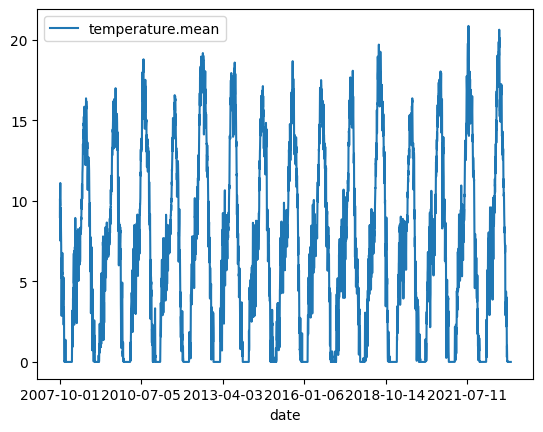

In [17]:
csd.plot.line(x="date", y="temperature.mean")

In a win for the three-sine model, the general form of the annual temperature cycle - with a clear spring-low - is quite distinct.  The question is whether that seasonal variation can be captured in a pseudophysical-statistical model or whether it requires direct approximation, TempEst 2-style.

<Axes: xlabel='tmax', ylabel='temperature.mean'>

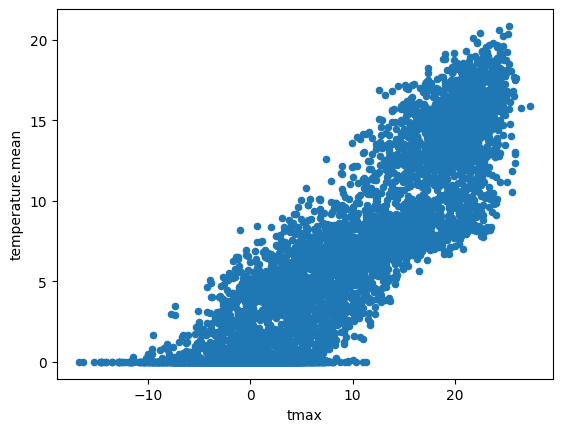

In [11]:
csd.plot.scatter(x="tmax", y="temperature.mean")

In [12]:
csd["DeltaT"] = csd["temperature.mean"].diff()
csd["DeltaAT"] = csd["tmax"].diff()

<Axes: xlabel='tmax', ylabel='DeltaT'>

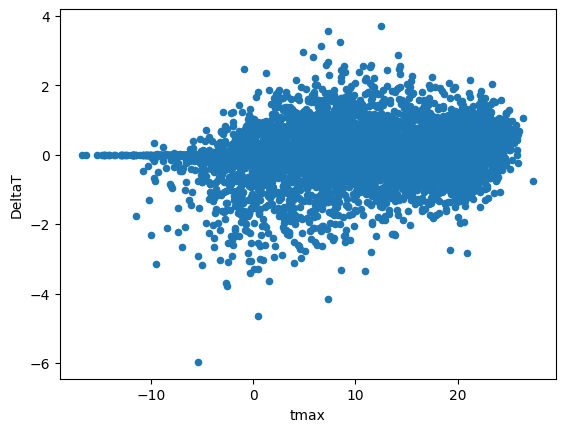

In [13]:
csd.plot.scatter(x="tmax", y="DeltaT")

<Axes: xlabel='swe', ylabel='temperature.mean'>

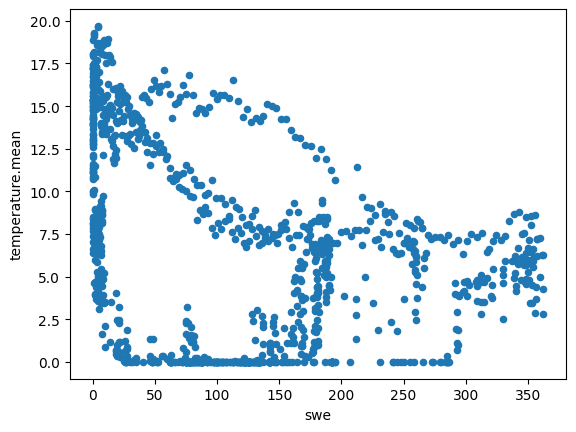

In [14]:
csd.plot.scatter(x="swe", y="temperature.mean")

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

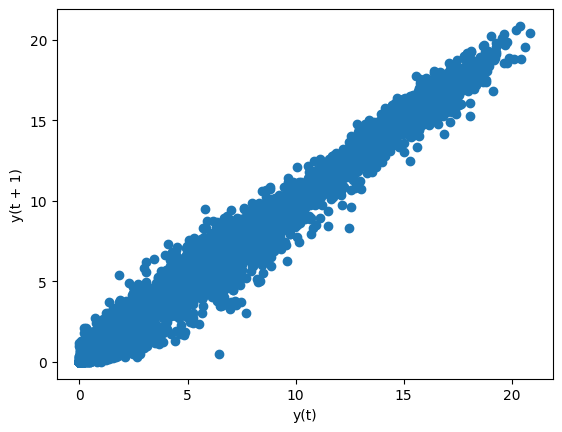

In [15]:
pdp.lag_plot(csd["temperature.mean"])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

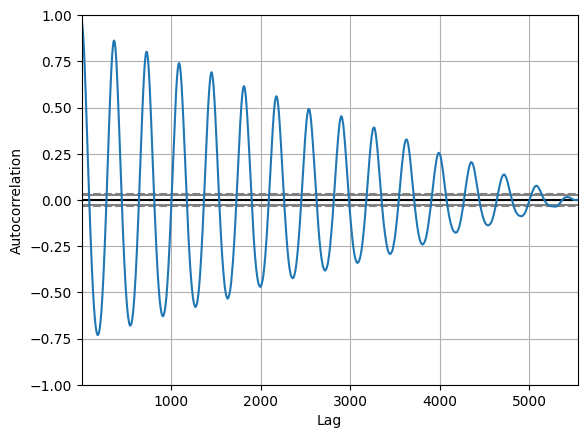

In [16]:
pdp.autocorrelation_plot(csd["temperature.mean"])

<Axes: xlabel='temperature.mean', ylabel='tmax'>

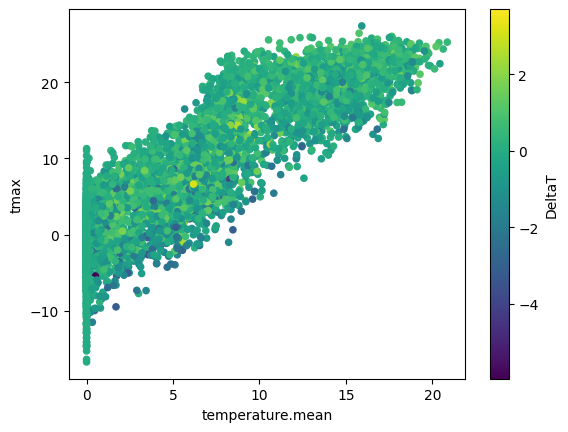

In [17]:
csd.plot.scatter(x="temperature.mean", y="tmax", c="DeltaT")

In [18]:
csd["doy"] = csd["date"].dt.day_of_year

<Axes: xlabel='doy', ylabel='DeltaT'>

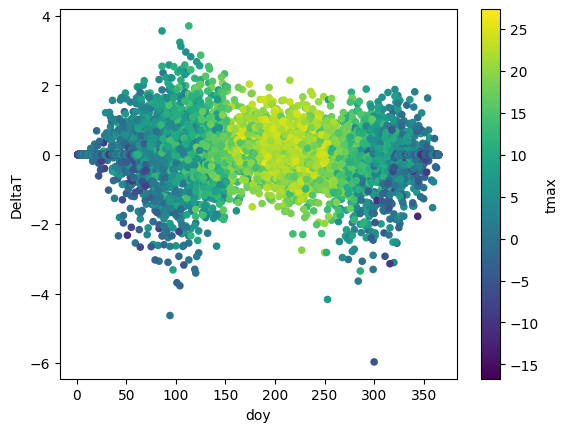

In [19]:
csd.plot.scatter(x="doy", c="tmax", y="DeltaT")

<Axes: xlabel='prcp', ylabel='DeltaT'>

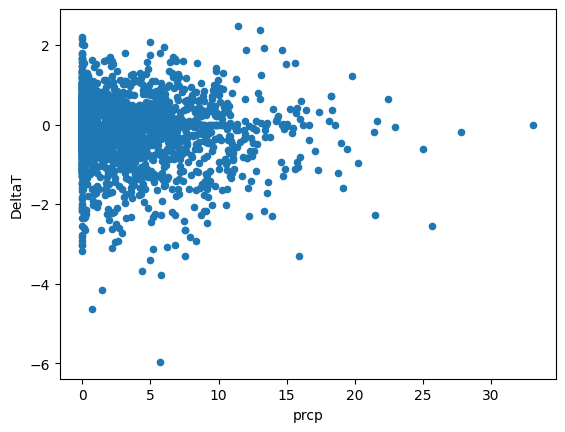

In [20]:
csd[csd["DeltaAT"] < 0].plot.scatter(x="prcp", y="DeltaT")

For Eagle River, the optimal correlation is with 18-day air temperature and mean water temperature.  Unsurprisingly, this has a sigmoidal form, but interestingly, it's actually flipped: rolling tmax appears to be a sigmoid of water temperature, not the other way around!  Now, when we color it by day-of-year, the pattern gains some clarity, and we see that the sigmoid actually reflects hysteresis driven by day-of-year norms, with the air temperature driving scatter more than the overall form.  The pattern is slightly noisier, but more obvious, using tmean (mean of minimum and maximum).

From the start of the year, water temperature increases linearly from zero to about 7-8 C while mean air temperatures increase to 0 C.  After that, the snowmelt dominates until air temperatures hit 10 C (a threshold which is probably driven by the amount of snow, not an exact number for air temperature), and water temperatures are nearly constant, with a very slight linear trend.  From air temperatures of 10-15 C (the maximum), there is a faster linear increase in water temperatures up to the maximum of about 18 C.  Then there's a steady, nearly linear (with a slight positive second derivative) decline back to 0 C, which seems to hit when air temperatures are consistently a little below freezing.

Some takeaways:

- The water is almost always *warmer* than the mean daily air temperature, presumably due to solar radiation (year-round), freezing, and groundwater (in colder months).
- Water warms up before the whole basin thaws.  Presumably, there's quite a bit of in-channel warming and warmer runoff in the lower part of the basin.
- The major snowmelt pulse fixes temperatures.  Seasonality of this could be estimated from basin characteristics, but it's worth seeing if there's a better way to do that using dynamic data.  A few thoughts:
  - Does this always happen (in snowy watersheds) at AT=0 C, or is there some other threshold?
  - Can we predict when it unsticks?  Is there a consistent snowpack or temperature threshold?
- The cooling limb of the thermograph (is there a word for that?) could be approximated quite accurately by a linear function from the maximum annual temperature down to the minimum, but we need a generic way to get the maximum and minimum coordinates.

Broadly, the seasonality is so dominant that a SCHEMA-like approach will almost certainly get the best performance, but I want to stay away from a stationary estimate of seasonality.  Instead, I should see if it's possible to dynamically identify seasonality thresholds and apply specialized regressions accordingly - assuming, of course, that this sort of pattern holds up.

                    RollAT  temperature.mean
RollAT            1.000000          0.864708
temperature.mean  0.864708          1.000000


<Axes: xlabel='RollAT', ylabel='temperature.mean'>

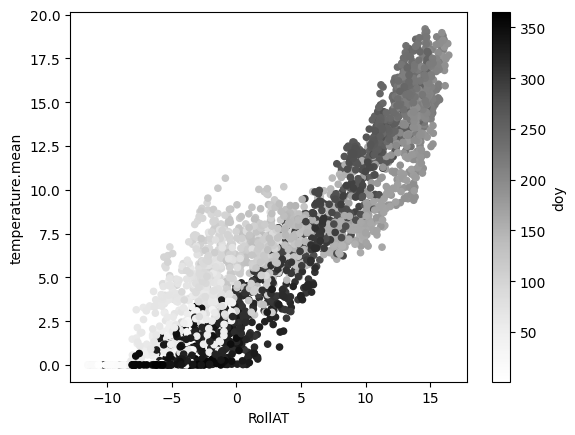

In [21]:
roll = 18  # best correlation
csd["RollAT"] = ((csd["tmax"] + csd["tmin"])/2).rolling(roll).mean()
print(csd[["RollAT", "temperature.mean"]].corr()**2)
csd.plot.scatter(x="RollAT", y="temperature.mean", c="doy")

In [95]:
csdssn = csd[["doy", "temperature.mean"]].rename(columns={"doy": "day", "temperature.mean": "temperature"})
ssn = rts.ThreeSine.from_data(csdssn.dropna()).generate_ts()
fitted = csdssn.merge(ssn, on="day")
print(fitted[["temperature", "actemp"]].corr()**2)
np.sqrt(np.mean((fitted["temperature"] - fitted["actemp"])**2))

             temperature    actemp
temperature     1.000000  0.927741
actemp          0.927741  1.000000


1.5264931554187946

<Axes: xlabel='doy', ylabel='temperature.mean'>

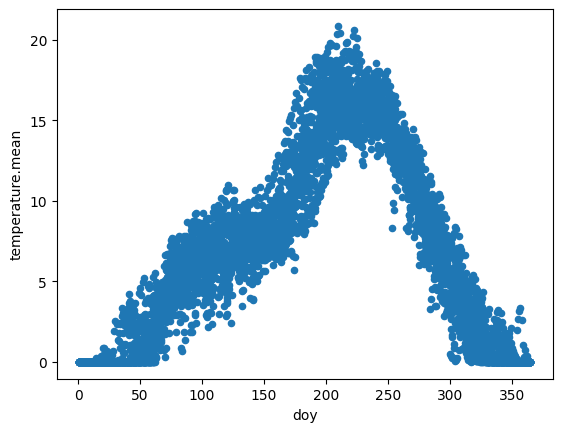

In [23]:
csd.plot.scatter(x="doy", y="temperature.mean")

Let's look at some specific years.

Overall:

- Warming started at -5 or -6 in 6/9 full-coverage years, but it could start as low as -10.
- Melt temperature was almost always 7-8 C, but some years had spikes above that and 2012 had no identifiable melt (low snow year?)
- Melt fixing began at about 0 C and ended at 8-10 C.
- Maximum water temperature was generally just slightly above maximum sustained air temperature.
- Freeze occurred between (0, 0) and (-5, 0).

In [24]:
csd["year"] = csd["date"].dt.year

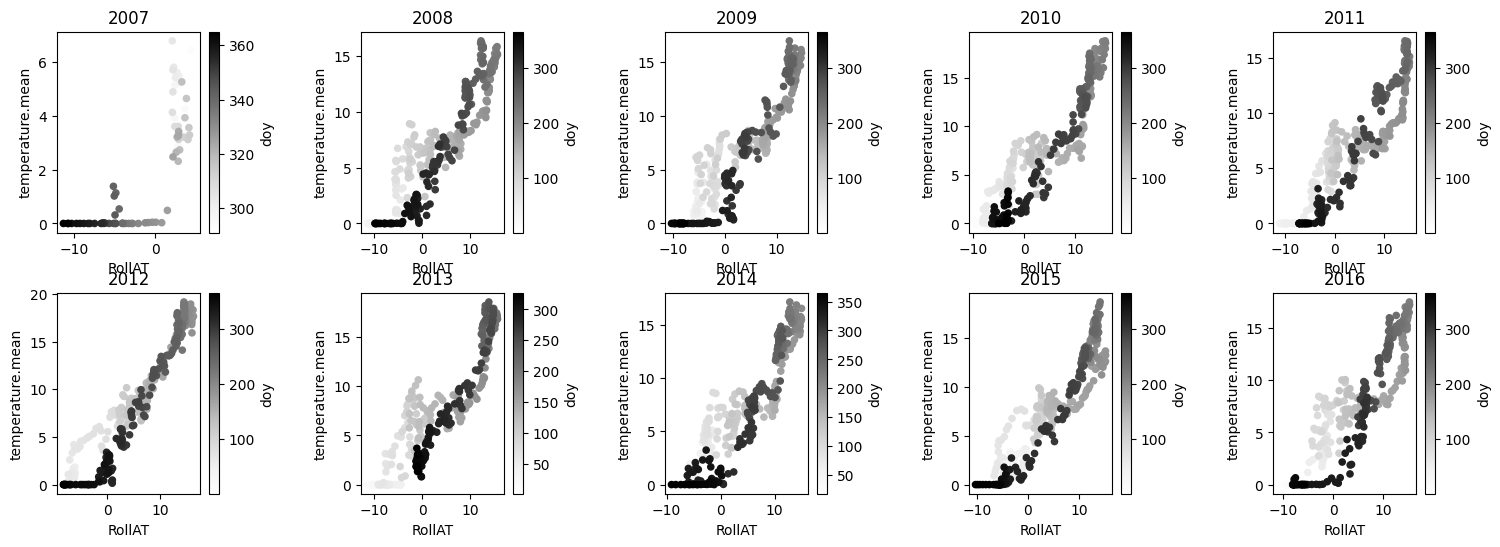

In [25]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(18,6))
plt.subplots_adjust(wspace=0.7, hspace=0.3)
for year in range(2007, 2017):
    x = (year - 2007) // 5
    y = (year - 2007) % 5
    csd[csd["year"]==year].plot.scatter(x="RollAT", y="temperature.mean", c="doy", ax=axes[x, y])
    axes[x, y].set_title(str(year))

# The Bayesian Season

## Overview

Context: stream temperature is dominated by seasonality, and I think a SCHEMA approach is pretty clearly the right conceptual framework for statistical ST modeling (that isn't full-blown ML).

However, this (specifically, SCHE; a semistatic estimate of MA would work fine) has two big shortcomings:

- It requires a lot of historical weather data, since SCHE components depend heavily on weather means
- It embeds the assumption of stationarity

So the dream would be to dynamically build a seasonal model as new weather data become available.  Does that make sense?  Well... you're basically just creating and updating a Bayesian prior!  (You could also guess a reasonably-intelligent prior from static conditions).

So what we can try doing is this:

- From static data, guess a prior for three-sine coefficients **and** some sort of air temperature seasonality (needed for MA).
- For each day of data, update both guesses and create a SCHEMA estimate.
- Some ideas for being smart about this:
	- Snowpack will drive seasonal anomaly coefficients and a lot of the timing, especially in the mountains
		- If there is major snowpack, the spring anomaly probably starts about when sustained air temperatures exceed freezing and ends when all or almost all the snow melts.  The end of the spring anomaly is the midpoint between the spring and summer anomaly peaks.
		- In the Eagle River case study, plot 3s days against SWE curve.
		- Not sure about magnitude, except that it'll increase with more snow.  Does the snowmelt energy getting sucked out of the air produce a recognizable effect on air-T where we could match magnitudes?
	- In the "cold north" regions (squished sine rather than lumpy curve), the whole thing is driven by freeze-thaw dynamics.  Can we guess from air temperature when water freezes and thaws?  Then we just need to guess the max. and it's pretty much a sine in between there.
	- In warm, low-elevation regions, we just need to guess the sine coefficients.
	- Air temperature variability probably drives a lot of the curve.  If we can define a general seasonal pattern for air temperature, we can probably compare the recent observed slope to that of a unit curve and guess the max and min (with a heavy weight towards the XYZ expectation, since that could get volatile).

## Approach

How do we try this out?

1. First, let's set a baseline: how well does a calibrated SCHEMA work? Look at $T=T_{doy}+f(weather)$.
2. Then, let's look at seasonality of weather and see if there's a usable match there.
3. Now try to guess it rolling forward for a case study (walk through it incrementally to see what's going on).
4. Finally, expand and see if we can identify a generalized approach.  Try correlating calibrated SCHEMA to long-term weather data, then see if we can work out an incremental guessing approach.

## What's the season?

From above, we know that in Eagle River the three-sine seasonality alone explains 93% of variation.  Below, it appears that it does well enough for air temperature as well, though obviously it is noisier.

In [29]:
wt_season = rts.ThreeSine.from_data(csdssn)
wt_season.to_df()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,R2,RMSE
0,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,NaN,0.574438


<Axes: xlabel='day', ylabel='temperature.mean'>

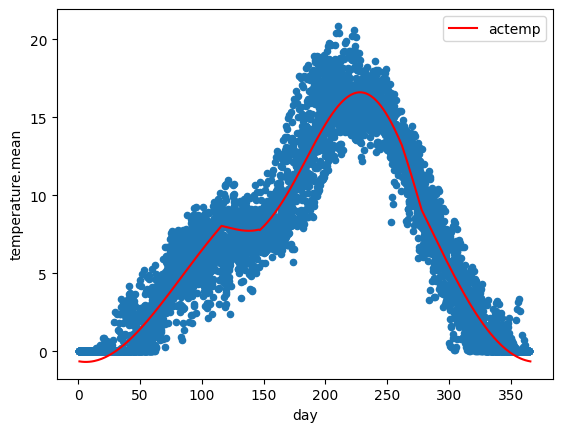

In [43]:
ax = csd.plot.scatter(x="doy", y="temperature.mean")
wt_season.generate_ts().plot.line(x="day", y="actemp", ax=ax, color="red")

In [83]:
csd["tmean"] = (csd["tmax"] + csd["tmin"])/2
at_season = rts.ThreeSine.from_data(csd[["doy", "tmean"]].rename(columns={"doy": "day", "tmean": "temperature"}))
atts = at_season.generate_ts()
at_season.to_df()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,R2,RMSE
0,3.156742,10.767704,351.0,75.0,131.0,200.0,0.796361,2.039754,NaN,1.287162


<Axes: xlabel='doy', ylabel='swe_n'>

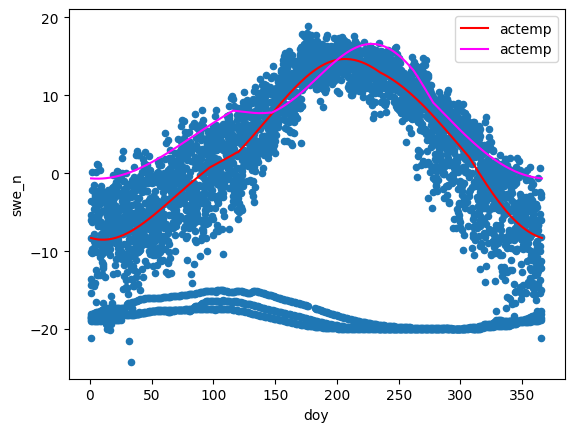

In [93]:
ax = csd.plot.scatter(x="doy", y="tmean")
atts.plot.line(x="day", y="actemp", ax=ax, color="red")
wt_season.generate_ts().plot.line(x="day", y="actemp", ax=ax, color="magenta")
csd.assign(swe_n = lambda x: x["swe"]/x["swe"].max()*5 - 20).plot.scatter(x="doy", y="swe_n", ax=ax)

We see that water temperature is generally warmer than mean air temperature, except during part of the spring snowmelt pulse - crossing points are at the end of constant water temperatures and then at maximum air temperature, after which water temperature still has some "thermal inertia".

For Eagle River, the water temperature spring-summer anomaly appears to start when SWE peaks, which makes sense.  The halfway (zero-effect) point of the spring-summer anomaly corresponds to three things: approx. zero SWE, maximum air temperature, and the peak of the air temperature summer anomaly.  I would guess that the actual driver is zero SWE.

<Axes: xlabel='day'>

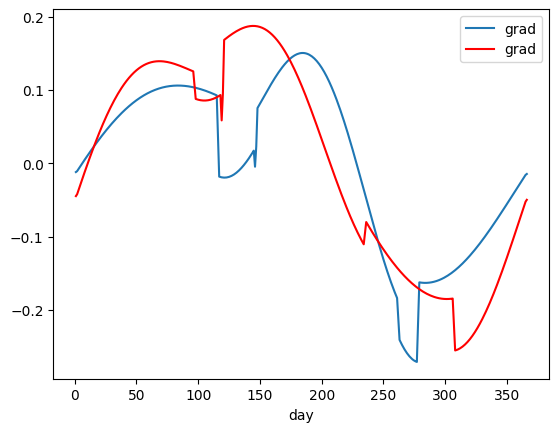

In [221]:
# Compare gradients rather than values
ax = wt_season.generate_ts().assign(grad=lambda x: np.gradient(x["actemp"])).plot(x="day", y="grad")
atts.assign(grad=lambda x: np.gradient(x["actemp"])).plot(x="day", y="grad", ax=ax, color="red")

In [53]:
fitted = csd.rename(columns={"doy": "day"}).merge(wt_season.generate_ts(), on="day").merge(atts.rename(columns={"actemp": "airssn"}), on="day")
fitted

,date,temperature.mean,prcp,srad,swe,tmax,tmin,vp,DeltaT,DeltaAT,day,RollAT,year,actemp,airssn
0,2007-10-01,9.000000,5.684494,315.89957,NaN,14.848049,-0.734184,579.70483,NaN,NaN,274,NaN,2007,10.141775,14.636594
1,2007-10-02,10.131250,1.734530,275.11975,NaN,9.678488,-0.441640,593.09650,1.131250,-5.169561,275,NaN,2007,9.872676,14.461007
2,2007-10-03,9.704167,0.000000,406.70746,NaN,14.444156,-0.781746,576.83930,-0.427083,4.765668,276,NaN,2007,9.602529,14.283946
3,2007-10-04,9.695833,0.405152,387.00244,NaN,16.709568,1.858799,699.66880,-0.008333,2.265412,277,NaN,2007,9.331561,14.105465
4,2007-10-05,10.901042,0.000000,334.83810,NaN,15.645824,3.965081,813.42255,1.205208,-1.063745,278,NaN,2007,9.059998,13.925616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,2022-12-27,0.000000,10.553032,191.49033,NaN,4.154530,NaN,424.24790,0.000000,1.840028,361,NaN,2022,-0.555511,-2.455855
5535,2022-12-28,0.000000,8.184340,210.25845,NaN,0.119703,NaN,298.54263,0.000000,-4.034827,362,NaN,2022,-0.580520,-2.526118
5536,2022-12-29,0.000000,1.973018,218.12827,NaN,-7.772742,NaN,180.07483,0.000000,-7.892445,363,NaN,2022,-0.602905,-2.590737
5537,2022-12-30,0.000000,7.100912,229.40940,NaN,-4.506784,NaN,182.08226,0.000000,3.265958,364,NaN,2022,-0.622671,-2.649723


          aaroll      anom
aaroll  1.000000  0.257977
anom    0.257977  1.000000


<Axes: xlabel='aaroll', ylabel='anom'>

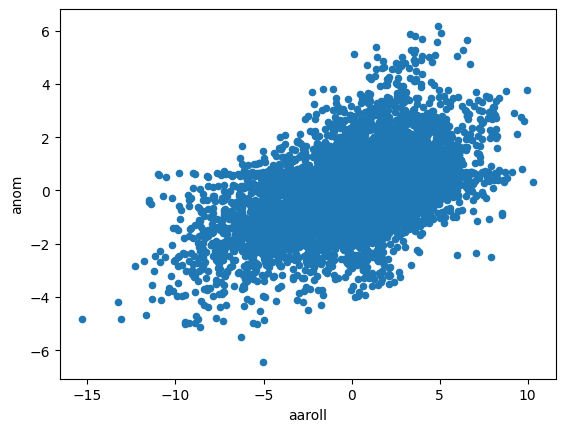

In [68]:
roll = 3  # optimal
fitted["anom"] = fitted["temperature.mean"] - fitted["actemp"]
fitted["anom_air"] = fitted["tmax"] - fitted["airssn"]
fitted["aaroll"] = fitted["anom_air"].rolling(roll).mean()
print(fitted[["aaroll", "anom"]].corr()**2)
fitted.plot.scatter(x="aaroll", y="anom")

In [76]:
fitted[["anom_air", "prcp", "swe", "anom"]].corr()

,anom_air,prcp,swe,anom
anom_air,1.000000,-0.346534,0.074282,0.414220
prcp,-0.346534,1.000000,0.094698,-0.057388
swe,0.074282,0.094698,1.000000,-0.151151
anom,0.414220,-0.057388,-0.151151,1.000000


In [97]:
tdata = csd.rename(columns={"doy": "day", "temperature.mean": "temperature"})
tdata

,date,temperature,prcp,srad,swe,tmax,tmin,vp,DeltaT,DeltaAT,day,RollAT,year,tmean
0,2007-10-01,9.000000,5.684494,315.89957,NaN,14.848049,-0.734184,579.70483,NaN,NaN,274,NaN,2007,7.056933
1,2007-10-02,10.131250,1.734530,275.11975,NaN,9.678488,-0.441640,593.09650,1.131250,-5.169561,275,NaN,2007,4.618424
2,2007-10-03,9.704167,0.000000,406.70746,NaN,14.444156,-0.781746,576.83930,-0.427083,4.765668,276,NaN,2007,6.831205
3,2007-10-04,9.695833,0.405152,387.00244,NaN,16.709568,1.858799,699.66880,-0.008333,2.265412,277,NaN,2007,9.284183
4,2007-10-05,10.901042,0.000000,334.83810,NaN,15.645824,3.965081,813.42255,1.205208,-1.063745,278,NaN,2007,9.805452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,2022-12-27,0.000000,10.553032,191.49033,NaN,4.154530,NaN,424.24790,0.000000,1.840028,361,NaN,2022,NaN
5535,2022-12-28,0.000000,8.184340,210.25845,NaN,0.119703,NaN,298.54263,0.000000,-4.034827,362,NaN,2022,NaN
5536,2022-12-29,0.000000,1.973018,218.12827,NaN,-7.772742,NaN,180.07483,0.000000,-7.892445,363,NaN,2022,NaN
5537,2022-12-30,0.000000,7.100912,229.40940,NaN,-4.506784,NaN,182.08226,0.000000,3.265958,364,NaN,2022,NaN


In [105]:
train = tdata[tdata["date"] < "2017-10-01"]
test = tdata[tdata["date"] >= "2017-10-01"]

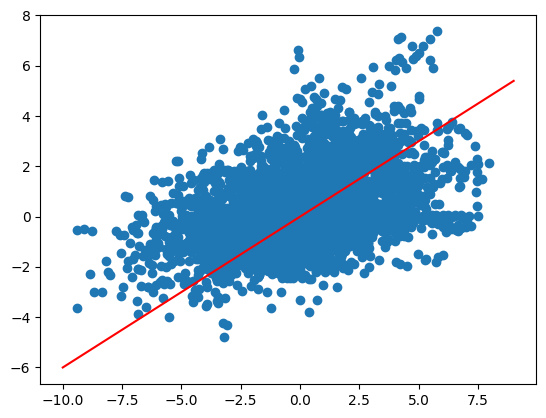

In [211]:
ssn = rts.ThreeSine.from_data(train)
wssn = train.merge(ssn.generate_ts(), on="day").merge(
    rts.ThreeSine.from_data(train[["day", "tmax"]].rename(columns={"tmax": "temperature"})).generate_ts().rename(columns={"actemp": "acair"}),
    on="day")
anom = wssn["temperature"] - wssn["actemp"]
x = (wssn["tmax"] - wssn["acair"]).rolling(7).mean()
plt.scatter(x, anom)
xt = np.arange(-10, 10)
plt.plot(xt, xt*0.6, color="red")
coef = 0.6
intercept = 0.0

In [212]:
test_prd = test.merge(ssn.generate_ts(), on="day").merge(
    rts.ThreeSine.from_data(train[["day", "tmax"]].rename(columns={"tmax": "temperature"})).generate_ts().rename(columns={"actemp": "acair"}),
    on="day").assign(modeled = lambda x: x["actemp"] + (x["tmax"] - x["acair"]).rolling(7).mean() * coef + intercept)

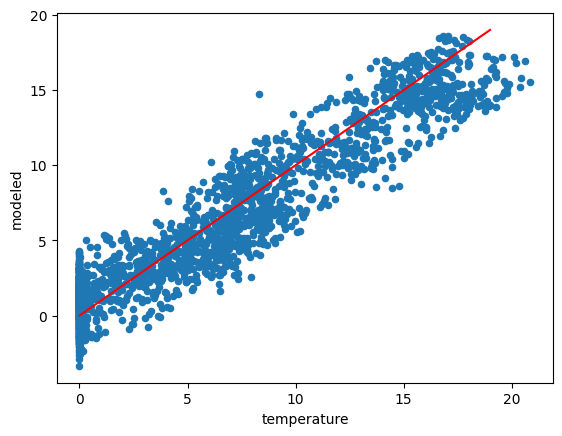

In [213]:
ax = test_prd.plot.scatter(x="temperature", y="modeled")
ax.plot(np.arange(0, 20), np.arange(0, 20), color="red")

In [215]:
test_prd[["temperature", "modeled"]].corr()**2

,temperature,modeled
temperature,1.000000,0.892314
modeled,0.892314,1.000000


In [217]:
np.sqrt(np.mean((test_prd["actemp"] - test_prd["temperature"])**2))

1.847131786568889

# Watershed Model Test

In [8]:
def cal_val(data):
    try:
        cut = round(data.shape[0] * 0.7)
        train = data[:cut]
        test = data[cut:]
        model = WS.from_data(train)
        return model.run_series(test)
    except:
        pass

In [9]:
csdrn = csd.rename(columns={"temperature.mean": "temperature"})
mod = WS.from_data(csdrn)

### Interlude: Do iterative and single-pass models behave similarly?

Answer: yes, they are effectively identical.  Good.

In [10]:
spp = mod.run_series(csdrn)
itr = mod.run_series_incremental(csdrn)
itr

,date,day,at,vp,actemp,anom,temp.mod
0,2007-10-01,274,14.848049,579.70483,9.243199,-0.021211,9.221989
1,2007-10-02,275,9.678488,593.09650,8.977150,-0.054608,8.922542
2,2007-10-03,276,14.444156,576.83930,8.710292,-0.038478,8.671814
3,2007-10-04,277,16.709568,699.66880,8.442873,0.068167,8.511040
4,2007-10-05,278,15.645824,813.42255,8.175141,0.320404,8.495545
...,...,...,...,...,...,...,...
5534,2022-12-27,361,4.154530,424.24790,-0.020726,0.775055,0.754329
5535,2022-12-28,362,0.119703,298.54263,-0.032142,1.164129,1.131987
5536,2022-12-29,363,-7.772742,180.07483,-0.041320,0.983409,0.942089
5537,2022-12-30,364,-4.506784,182.08226,-0.048276,0.009779,-0.038497


<Axes: xlabel='date'>

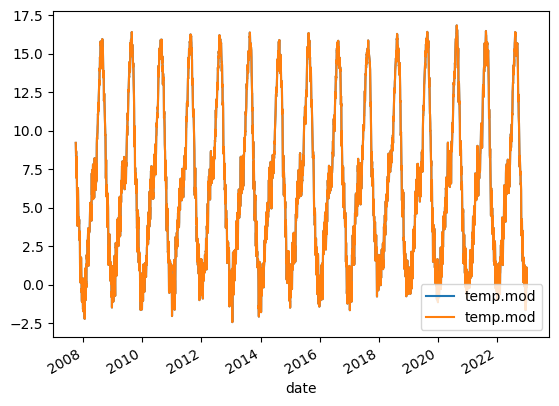

In [14]:
ax = spp.plot(x="date", y="temp.mod")
itr.plot(x="date", y="temp.mod", ax=ax)

In [15]:
spp["temp.mod"].corr(itr["temp.mod"])

0.9999993669385356

### Back to the test

In [11]:
pr = cal_val(csdrn)

C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\newt\src\NEWT\watershed.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day"] = data["date"].dt.day_of_year
C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\newt\src\NEWT\watershed.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day"] = data["date"].dt.day_of_year


In [12]:
pr

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,day,actemp,anom,temp.mod
0,394220106431500,2018-06-13,11.882292,0.000000,539.31830,59.425697,22.561752,NaN,826.84326,164,8.472777,0.043983,8.516760
1,394220106431500,2018-06-14,12.295833,0.000000,433.09134,56.284252,20.266445,NaN,1021.83826,165,8.574972,0.910761,9.485733
2,394220106431500,2018-06-15,12.284375,0.021201,467.74030,53.393375,20.622587,NaN,928.80725,166,8.680283,0.986670,9.666953
3,394220106431500,2018-06-16,12.648958,7.487349,307.32434,50.764553,16.977766,NaN,1024.71570,167,8.788646,0.868212,9.656858
4,394220106431500,2018-06-17,12.180208,18.996042,294.39838,48.326603,15.841060,NaN,981.30860,168,8.899993,0.232799,9.132791
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,394220106431500,2022-12-27,0.000000,10.553032,191.49033,NaN,4.154530,NaN,424.24790,361,-0.020726,0.962078,0.941352
1658,394220106431500,2022-12-28,0.000000,8.184340,210.25845,NaN,0.119703,NaN,298.54263,362,-0.032142,1.303593,1.271451
1659,394220106431500,2022-12-29,0.000000,1.973018,218.12827,NaN,-7.772742,NaN,180.07483,363,-0.041320,0.945150,0.903831
1660,394220106431500,2022-12-30,0.000000,7.100912,229.40940,NaN,-4.506784,NaN,182.08226,364,-0.048276,-0.139500,-0.187777


<Axes: xlabel='date'>

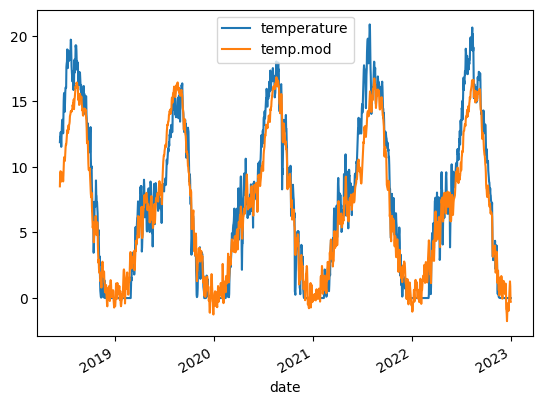

In [19]:
ax = pr.plot(x="date", y="temperature")
pr.plot(x="date", y="temp.mod", ax=ax)

In [32]:
def perf(pr):
    return pd.DataFrame({
        "R2": [pr["temperature"].corr(pr["temp.mod"])**2],
        "RMSE": np.sqrt(np.mean((pr["temp.mod"] - pr["temperature"])**2)),
        "NSE": 1 - np.mean((pr["temp.mod"] - pr["temperature"])**2) / np.std(pr["temperature"])**2,
        "Pbias": np.mean(pr["temp.mod"] - pr["temperature"]) / np.mean(pr["temperature"])*100,
        "Bias": np.mean(pr["temp.mod"] - pr["temperature"])
    })
perf(pr)

,R2,RMSE,NSE,Pbias,Bias
0,0.936597,1.758563,0.917577,-7.176714,-0.526501


In [30]:
preds = data.rename(columns={"temperature.mean": "temperature"}).groupby("id").apply(cal_val, include_groups=False)

In [31]:
preds

date  temperature       prcp        srad  swe  \
id                                                                         
01010000        0    2014-10-22     6.789583   1.451763  196.096630  0.0   
                1    2014-10-23     7.188542  18.446787   84.404945  0.0   
                2    2014-10-24     7.115625   2.005072   86.606360  0.0   
                3    2014-10-25     7.248958   6.381760  186.072240  0.0   
                4    2014-10-26     7.626042   3.868103   61.989770  0.0   
...                         ...          ...        ...         ...  ...   
453004122510301 1663 2022-12-27     8.954167  14.705484  102.965160  NaN   
                1664 2022-12-28     8.227083   7.167581   75.575645  NaN   
                1665 2022-12-29     7.947917  12.223548   76.049675  NaN   
                1666 2022-12-30     8.160417   7.248064   86.775970  NaN   
                1667 2022-12-31     8.472917   1.040323  103.396450  NaN   

                           tmax      tmin         vp  day    actemp      anom  \
id                                                                              
01010000        0     10.281011  0.852441  650.17360  295  9.808999 -0.111854   
                1      6.834916  2.390627  725.62463  296  9.609810  0.079116   
                2      6.292076  2.558955  734.42580  297  9.410310  0.254878   
                3     13.149472  1.213496  667.40265  298  9.210559  0.475581   
                4      7.058496  4.062082  816.76074  299  8.848482  1.523906   
...                         ...       ...        ...  ...       ...       ...   
453004122510301 1663  12.431773       NaN  926.78296  361  5.397861  2.161932   
                1664   8.427581       NaN  822.70820  362  5.366050  2.705219   
                1665   8.684195       NaN  839.17084  363  5.337013  1.404091   
                1666  10.729195       NaN  917.87340  364  5.310735  1.670563   
                1667   9.031774       NaN  856.59326  365  5.287198  2.589400   

                       temp.mod  
id                               
01010000        0      9.697144  
                1      9.688926  
                2      9.665189  
                3      9.686140  
                4     10.372388  
...                         ...  
453004122510301 1663   7.559793  
                1664   8.071269  
                1665   6.741104  
                1666   6.981298  
                1667   7.876598  

[731040 rows x 12 columns]

In [33]:
preds.groupby("id").apply(perf).describe()

,R2,RMSE,NSE,Pbias,Bias
count,570.000000,570.000000,570.000000,570.000000,570.000000
mean,0.920406,1.938503,0.862231,-3.555133,-0.250598
std,0.122074,5.641348,0.493958,5.969355,4.897644
min,0.029580,0.353829,-7.505420,-77.409865,-3.052459
25%,0.929108,1.396025,0.906717,-6.671525,-0.849760
50%,0.955083,1.611782,0.941442,-3.923307,-0.514914
75%,0.969008,1.880454,0.955868,-0.642640,-0.081686
max,0.985198,135.716165,0.982152,26.066513,115.434081


So far so good: across the sample, median R2 is 0.96 (!), RMSE is 1.6 C, NSE is 0.94.  Not too shabby, though there'll be some penalty in coefficient estimation.  On the other hand, there'll hopefully be some improvement from climate-drift and smart seasonality.